# Neural Belief Propagation Decoding of Quantum LDPC Codes Using Overcomplete Check Matrices
## Sisi Miao, Alexander Schnerring, Haizheng Li, and Laurent Schmalen

The recent success in constructing asymptotically good quantum low-density parity-check (QLDPC) codes makes this family of codes a promising candidate for error-correcting schemes in quantum computing. However, conventional belief propagation (BP) decoding of QLDPC codes does not yield satisfying performance due to the presence of unavoidable short cycles in their Tanner graph and the special degeneracy phenomenon. In this work, we propose to decode QLDPC codes based on a check matrix with redundant rows, generated from linear combinations of the rows in the original check matrix. This approach yields a significant improvement in decoding performance with the additional advantage of very low decoding latency. Furthermore, we propose a novel neural belief propagation decoder based on the quaternary BP decoder of QLDPC codes which leads to further decoding performance improvements.

This jupyter notebook provides the implementation which produces the results in [1]. In specific, this notebook contains:
* The neural BP(NBP) decoder
* The function for training, can be run on CPU or GPU
* Call on the C++ functions which evaluate the trained decoder
* Addtionally, the overcomplete check matrices used in [1] are provided in the ./PCM folder

[1] S. Miao, A. Schnerring, H. Li and L. Schmalen, "Neural belief propagation decoding of quantum LDPC codes using overcomplete check matrices," Proc. IEEE Inform. Theory Workshop (ITW), Saint-Malo, France, Apr. 2023, https://arxiv.org/abs/2212.10245

This work has received funding from the European Research Council (ERC) under the European Union's Horizon 2020 research and innovation programme (grant agreement No. 101001899).

The code in this file: Copyright 2023 Sisi Miao, Communications Engineering Lab @ KIT.

This source code is supplied under [MIT License](https://github.com/kit-cel/Quantum-Neural-BP4-demo/blob/master/LICENSE.md).

In [1]:
#Import external libraries
import torch
import sys
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm
import random
import matplotlib.pylab as plt

In [2]:
class NBP_oc(nn.Module):
    def __init__(self, n: int, k: int, m: int, m1: int, m2: int, codeType: str, n_iterations: int,
                 folder_weights: str = None,
                 batch_size: int = 1):
        super().__init__()
        self.name = "Neural_BP_Decoder"
        self.batch_size = batch_size
        self.codeType = codeType
        self.n = n # physical qubit の数
        self.k = k # logical qubit の数
        #m_oc is the number rows of the overcomplete check matrix
        self.m_oc = m
        self.m1 = m1
        self.m2 = m2
        #m is the number of rows of the full rank check matrix
        self.m = n - k
        #If True, then all outgoing edges on the same CN has the same weight, configurable
        self.one_weight_per_cn = True
        self.rate = self.k / self.n
        self.n_iterations = n_iterations # BP の iter数
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.xhat = torch.zeros((batch_size, self.n))
        self.zhat = torch.zeros((batch_size, self.n))
        self.load_matrices()

        if not folder_weights:
            #initilize weights with 1 if none given
            self.ini_weight_as_one(n_iterations)
        else:
            # load pretrained weights stored in directory "folder":
            self.load_weights(folder_weights, self.device)

    def fx(self, a: torch.tensor, b: torch.tensor) -> torch.Tensor:
        # ln(exp(x)+exp(y)) = max(x,y)+ln(1+exp(-|x-y|)
        return torch.max(a, b) + self.log1pexp(-1 * torch.abs(a - b))

    def log1pexp(self, x):
        # more stable version of log(1 + exp(x))
        m = nn.Softplus(beta=1, threshold=50)
        return m(x)

    def calculate_self_syn(self):
        # Hz と errorx の積で良い？
        # errorx, errorz: (batch_size, n)
        # Hx, Hz: (1, m1 or m2, n)
        # synx, synz: (batch_size, m1 or m2, 1)
        
        self.synx = torch.matmul(self.Hz, torch.transpose(self.errorx, 0, 1)) # transpose: 軸を入れ替える
        self.synz = torch.matmul(self.Hx, torch.transpose(self.errorz, 0, 1))
        self.synx = torch.remainder(torch.transpose(self.synx, 2, 0), 2) # remainder: 余り
        self.synz = torch.remainder(torch.transpose(self.synz, 2, 0), 2)
        return torch.cat((self.synz, self.synx), dim=1)

    def loss(self, Gamma) -> torch.Tensor:
        """loss functions proposed in [1] eq. 11"""

        # first row, anti-commute with X, second row, anti-commute with Z, [1] eq. 10
        # 1列目、Xとのアンチコミュート、2列目、Zとのアンチコミュート [1] 式10
        prob = torch.sigmoid(-1.0 * Gamma).float()

        prob_aX = prob[:, 0, :]
        prob_aZ = prob[:, 1, :]

        assert not torch.isinf(prob_aX).any()
        assert not torch.isinf(prob_aZ).any()
        assert not torch.isnan(prob_aX).any()
        assert not torch.isnan(prob_aZ).any()

        #Depend on if the error commute with the entries in S_dual, which is denoted as G here
        #CSS constructions gives the simplification that Gx contains only X entries, and Gz contains on Z
        #誤差がS_dualのエントリと一致するかどうかに依存する。
        #GxはXの項目のみを含み、GzはZの項目のみを含む。
        correctionx = torch.zeros_like(self.errorx)
        correctionz = torch.zeros_like(self.errorz)

        correctionz[self.qx == 1] = prob_aX[self.qx == 1]
        correctionz[self.qz == 1] = 1 - prob_aX[self.qz == 1]
        correctionz[self.qy == 1] = 1 - prob_aX[self.qy == 1]
        correctionz[self.qi == 1] = prob_aX[self.qi == 1]

        correctionx[self.qz == 1] = prob_aZ[self.qz == 1]
        correctionx[self.qx == 1] = 1 - prob_aZ[self.qx == 1]
        correctionx[self.qy == 1] = 1 - prob_aZ[self.qy == 1]
        correctionx[self.qi == 1] = prob_aZ[self.qi == 1]

        #first summ up the probability of anti-commute for all elements in each row of G
        #まず、Gの各行の全要素について、アンチコミュートの確率を合計する。
        synx = torch.matmul(self.Gz, torch.transpose(correctionx.float(), 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz.float(), 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        syn_real = torch.cat((synz, synx), dim=1)

        #the take the sin function, then summed up for all rows of G
        #sin関数をとり、Gのすべての行について合計する。
        loss = torch.zeros(1, self.batch_size)
        for b in range(self.batch_size):
            loss[0, b] = torch.sum(torch.abs(torch.sin(np.pi / 2 * syn_real[b, :, :])))

        assert not torch.isnan(loss).any()
        assert not torch.isinf(loss).any()

        return loss

    def variable_node_update(self, incoming_messages, llr, weights_vn, weights_llr):
        # As we deal with CSS codes, all non-zero entries on the upper part anti-commute with Z and Y and commute with X
        # all non-zero entries on the upper part anti-commute with X and Y and commute with Z
        # Then the calculation can be done in matrices => speed up training (probably)
        # CSSコードを扱うので、上部の非ゼロエントリーはすべてZとYと反共約し、Xと共約する。
        # 上部のすべての非ゼロエントリは X および Y と反共約し、Z と共約する。
        # すると計算は行列でできる => トレーニングのスピードアップ（たぶん）
        incoming_messages_upper = incoming_messages[:, 0:self.m1, :]
        incoming_messages_lower = incoming_messages[:, self.m1:self.m_oc, :]
        incoming_messages_upper.to(self.device)
        incoming_messages_lower.to(self.device)

        Gammaz = llr * weights_llr + torch.sum(incoming_messages_upper, dim=1, keepdim=True)
        Gammax = llr * weights_llr + torch.sum(incoming_messages_lower, dim=1, keepdim=True)
        Gammay = llr * weights_llr + torch.sum(incoming_messages, dim=1, keepdim=True)

        Gammaz.double().to(self.device)
        Gammax.double().to(self.device)
        Gammay.double().to(self.device)
        
        #can be re-used for hard-decision in decoding, but not used in training as we don't check for decoding success
        #we are only interested in the loss during training
        #デコード時のハード判定に再利用できるが、デコードの成功をチェックしないため、トレーニングでは使用しない。
        #我々はトレーニング中の損失にしか興味がない。
        Gamma = torch.cat((Gammay, Gammax, Gammaz), dim=1).to(self.device)

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        
        outgoing_messages_upper = self.log1pexp(-1.0 * Gammax) - self.fx(-1.0 * Gammaz, -1.0 * Gammay)
        outgoing_messages_lower = self.log1pexp(-1.0 * Gammaz) - self.fx(-1.0 * Gammax, -1.0 * Gammay)
        Gamma_all = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1).to(self.device)

        outgoing_messages_upper = outgoing_messages_upper * self.Hx
        outgoing_messages_lower = outgoing_messages_lower * self.Hz
        outgoing_messages = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1)

        outgoing_messages = outgoing_messages - incoming_messages
        outgoing_messages = outgoing_messages * self.H

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        #to avoid numerical issues
        #数値的な問題を避けるため
        outgoing_messages = torch.clip(outgoing_messages, -30.0, 30.0)

        return outgoing_messages.float() * weights_vn, Gamma, Gamma_all

    def check_node_update(self, incoming_messages: torch.Tensor, weights_cn: torch.Tensor) -> torch.Tensor:
        multipicator = torch.pow(-1, self.syn)
        multipicator = multipicator * self.H

        # use the simplification with the phi function to turn multipilication to addtion
        # a bit more troublesome than the usual SPA, because want to do it in matrix
        # 乗算を加算に変えるために phi 関数を使った単純化を使う
        # 通常の SPA よりも少し面倒である。
        incoming_messages_sign = torch.sign(incoming_messages) # torch.sign: 1. or -1. or 0. を返す
        incoming_messages_sign[incoming_messages == 0] = 1
        first_part = torch.prod(incoming_messages_sign, dim=2, keepdim=True) # 要素の積をとって 2 番目の次元を削除する
        first_part = first_part * self.H
        first_part = first_part / incoming_messages_sign
        first_part = self.H * first_part
        assert not torch.isinf(first_part).any()
        assert not torch.isnan(first_part).any()

        incoming_messages_abs = torch.abs(incoming_messages).double()
        helper = torch.ones_like(incoming_messages_abs)
        helper[incoming_messages_abs == 0] = 0
        incoming_messages_abs[incoming_messages == 0] = 1.0

        phi_incoming_messages = -1.0 * torch.log(torch.tanh(incoming_messages_abs / 2.0))
        phi_incoming_messages = phi_incoming_messages * helper
        phi_incoming_messages = phi_incoming_messages * self.H

        temp = torch.sum(phi_incoming_messages, dim=2, keepdim=True)
        Aij = temp * self.H

        sum_msg = Aij - phi_incoming_messages
        helper = torch.ones_like(sum_msg)
        helper[sum_msg == 0] = 0
        sum_msg[sum_msg == 0] = 1.0

        second_part = -1 * torch.log(torch.tanh(sum_msg / 2.0))
        second_part = second_part * helper
        second_part = second_part * self.H
        assert not torch.isinf(second_part).any()
        assert not torch.isnan(second_part).any()

        outgoing_messages = first_part * second_part
        outgoing_messages = outgoing_messages * multipicator

        outgoing_messages = (outgoing_messages * weights_cn).float()
        return outgoing_messages

    def forward(self, errorx: torch.Tensor, errorz: torch.Tensor, ep: float, batch_size=1) -> torch.Tensor:
        """main decoding procedure"""
        loss_array = torch.zeros(self.batch_size, self.n_iterations).float().to(self.device)
        
        # batch_size != self.batch_size のときに例外を投げる
        assert batch_size == self.batch_size

        self.errorx = errorx.to(self.device)
        self.errorz = errorz.to(self.device)

        # 4 次信念伝播なので 4 変数
        self.qx = torch.zeros_like(self.errorx)
        self.qz = torch.zeros_like(self.errorx)
        self.qy = torch.zeros_like(self.errorx)
        self.qi = torch.ones_like(self.errorx)

        # x エラーの箇所を 1 にしてから, z エラーがある箇所 (y エラー) を除く
        self.qx[self.errorx == 1] = 1
        self.qx[self.errorz == 1] = 0

        # z エラーの箇所を 1 にしてから, x エラーがある箇所 (y エラー) を除く
        self.qz[self.errorz == 1] = 1
        self.qz[self.errorx == 1] = 0

        # 一旦 z エラーの箇所を y エラーとしてから, x エラーが無い箇所を除く
        self.qy[self.errorz == 1] = 1
        self.qy[self.errorx != self.errorz] = 0

        # qi は初め 1 で初期化していることに注意
        # エラーのある箇所を除く
        self.qi[self.errorx == 1] = 0
        self.qi[self.errorz == 1] = 0

        self.syn = self.calculate_self_syn()

        #initial LLR to, first equation in [1,Sec.II-C]
        llr = np.log(3 * (1 - ep) / ep)

        messages_cn_to_vn = torch.zeros((batch_size, self.m_oc, self.n)).to(self.device)
        self.batch_size = batch_size

        # initlize VN message
        messages_vn_to_cn, _, _ = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[0],
                                                            self.weights_llr[0])

        # iteratively decode, decode will continue till the max. iteration, even if the syndrome already matched
        # 反復デコードでは、シンドロームがすでにマッチしていても、デコードは最大反復まで続けられる。
        for i in range(self.n_iterations):

            assert not torch.isnan(self.weights_llr[i]).any()
            assert not torch.isnan(self.weights_cn[i]).any()
            assert not torch.isnan(messages_cn_to_vn).any()

            # check node update:
            messages_cn_to_vn = self.check_node_update(messages_vn_to_cn, self.weights_cn[i])

            assert not torch.isnan(messages_cn_to_vn).any()
            assert not torch.isinf(messages_cn_to_vn).any()

            # variable node update:
            messages_vn_to_cn, Tau, Tau_all = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[i + 1],
                                                                        self.weights_llr[i + 1])

            assert not torch.isnan(messages_vn_to_cn).any()
            assert not torch.isinf(messages_vn_to_cn).any()
            assert not torch.isnan(Tau).any()
            assert not torch.isinf(Tau).any()

            loss_array[:, i] = self.loss(Tau_all)


        _, minIdx = torch.min(loss_array, dim=1, keepdim=False)


        loss = torch.zeros(self.batch_size, ).float().to(self.device)
        #take average of the loss for the first iterations till the loss is minimized
        #損失が最小になるまでの、最初の反復の損失の平均をとる。
        for b in range(batch_size):
            for idx in range(minIdx[b] + 1):
                loss[b] += loss_array[b, idx]
            loss[b] /= (minIdx[b] + 1)

        loss = torch.sum(loss, dim=0) / self.batch_size

        assert not torch.isnan(loss)
        assert not torch.isinf(loss)
        return loss
    
    
    def check_syndrome(self, Tau):
        """performs hard decision to give the estimated error and check for decoding success.
        However, not used in the current script, as we are only performing trainig"""
        """推定誤差を与えるハード判定を行い、デコードの成功をチェックする。
        しかし、今回のスクリプトでは学習のみを行うため、使用しない。"""
        tmp = torch.zeros(self.batch_size, 1, self.n).to(self.device)
        Tau = torch.cat((tmp, Tau), dim=1)

        minVal, minIdx = torch.min(Tau, dim=1, keepdim=False)

        self.xhat = torch.zeros((self.batch_size, self.n)).to(self.device)
        self.zhat = torch.zeros((self.batch_size, self.n)).to(self.device)

        self.xhat[minIdx == 1] = 1
        self.xhat[minIdx == 2] = 1

        self.zhat[minIdx == 1] = 1
        self.zhat[minIdx == 3] = 1
        m = torch.nn.ReLU()

        synx = torch.matmul(self.Hz, torch.transpose(self.xhat, 0, 1))
        synz = torch.matmul(self.Hx, torch.transpose(self.zhat, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        synhat = torch.remainder(torch.cat((synz, synx), dim=1), 2)

        syn_match = torch.all(torch.all(torch.eq(self.syn, synhat), dim=1), dim=1)

        correctionx = torch.remainder(self.xhat + self.errorx, 2)
        correctionz = torch.remainder(self.zhat + self.errorz, 2)
        synx = torch.matmul(self.Gz, torch.transpose(correctionx, 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        self.syn_real = torch.cat((synz, synx), dim=1)

        syn_real = torch.remainder(self.syn_real, 2)
        tmmp = torch.sum(syn_real, dim=1, keepdim=False)
        success = torch.all(torch.eq(torch.sum(syn_real, dim=1, keepdim=False), 0), dim=1)
        return syn_match, success
    
    
    
    def unsqueeze_batches(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Checks if tensor is 2D or 3D. If tensor is 2D, insert extra dimension (first dimension)
        This method can be used to allow decoding of
            batches of codewords (batch size, m, n)
            as well as single codewords (m, n)
        """
        """
        テンソルが2次元か3次元かを調べる。テンソルが2Dの場合、余分な次元（1次元目）を挿入する。
        このメソッドは
            コードワードのバッチ(バッチサイズ、m, n)
            単一のコードワード(m, n)と同様に
        """
        if tensor.dim() == 3:
            return tensor
        elif tensor.dim() == 2:
            return torch.unsqueeze(tensor, dim=0)

    #continue with the NBP_oc class, some tool functions
    #NBP_ocクラスを継続し、いくつかのツール機能を追加する。
    def load_matrices(self):
        """reads in the check matrix for decoding as well as the dual matrix for checking decoding success"""
        """デコードのためのチェックマトリックスと、デコードの成功をチェックするためのデュアルマトリックスを読み込む"""
        file_nameGx = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gx.alist"
        file_nameGz = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gz.alist"
        Gx = readAlist(file_nameGx)
        Gz = readAlist(file_nameGz)

        file_nameH = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_H_" + str(self.m_oc) + ".alist"

        H = readAlist(file_nameH)
        self.H = H
        Hx = H[0:self.m1, :]
        Hz = H[self.m1:self.m_oc, :]
        Gx = torch.from_numpy(Gx).float()
        Gz = torch.from_numpy(Gz).float()
        Hx = torch.from_numpy(Hx).float()
        Hz = torch.from_numpy(Hz).float()


        # first dim for batches.
        self.Hx = self.unsqueeze_batches(Hx).float().to(self.device)
        self.Hz = self.unsqueeze_batches(Hz).float().to(self.device)
        self.Gx = self.unsqueeze_batches(Gx).float().to(self.device)
        self.Gz = self.unsqueeze_batches(Gz).float().to(self.device)

        self.H = torch.cat((self.Hx, self.Hz), dim=1).float().to(self.device)
        self.H_reverse = 1 - self.H

    def ini_weight_as_one(self, n_iterations: int):
        """this function can be configured to determine which parameters are trainable"""
        """この関数は、どのパラメーターが訓練可能かを決定するために設定することができる"""
        self.weights_llr = [] # log-likelihood ratio
        self.weights_cn = []
        self.weights_vn = []
        for i in range(n_iterations):
            if self.one_weight_per_cn:
                self.weights_cn.append(torch.ones((1, self.m_oc, 1), requires_grad=True, device=self.device))
            else:
                self.weights_cn.append(torch.ones((1, self.m_oc, self.n), requires_grad=True, device=self.device))
            self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=True, device=self.device))
            self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=False, device=self.device))
        self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=False, device=self.device))
        self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=True, device=self.device))

    def save_weights(self):
        """weights are saved twice, once as .pt for python, once as .txt for c++"""
        """重みは2回保存されます。1回はpython用の.ptとして、もう1回はc++用の.txtとして保存されます"""
        "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/"
        os.makedirs(path, exist_ok=True)
        #some parameters may not be trained, but we save them anyway
        file_vn = "weights_vn.pt"
        file_cn = "weights_cn.pt"
        file_llr = "weights_llr.pt"

        torch.save(self.weights_vn, os.path.join(path, file_vn))
        torch.save(self.weights_cn, os.path.join(path, file_cn))
        torch.save(self.weights_llr, os.path.join(path, file_llr))
        print(f'  weights saved to {file_cn},{file_vn}, and {file_llr}.\n')

        # the following codes save the weights into txt files, which is used for C++ code for evaluating the trained
        # decoder. So the C++ codes don't need to mess around with python packages
        # not very elegant but will do for now
        # 以下のコードは重みをtxtファイルに保存する。
        # C++ コードに使用される。そのため、C++のコードはpythonのパッケージをいじる必要がない。
        # あまりエレガントではないが、今のところはこれで十分だろう
        if sys.version_info[0] == 2:
            import cStringIO
            StringIO = cStringIO.StringIO
        else:
            import io

        StringIO = io.StringIO

        # write llr weights, easy
        f = open(path + "weight_llr.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_llr)))
            for i in self.weights_llr:
                data = i.detach().cpu().numpy().reshape(self.n, 1)
                opt = ["%.16f" % i for i in data]
                output.write(' '.join(opt))
                output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write CN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_cn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_cn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxRowWeight = max(rowWeights)

            if self.one_weight_per_cn:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, 1)
                    for rowId in range(nRows):
                        opt = ["%.16f" % i for i in matrix[rowId]]
                        for i in range(rowWeights[rowId].astype('int') - 1):
                            output.write(opt[0])
                            output.write(' ')
                        output.write(opt[0])
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - rowWeights[rowId] - 1).astype('int'))
                        output.write('\n')
            else:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                    matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                    for rowId in range(nRows):
                        nonzeroIndices = np.flatnonzero(matrix[rowId, :])  # AList uses 1-based indexing
                        output.write(' '.join(map(str, matrix[rowId, nonzeroIndices])))
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - len(nonzeroIndices)))
                        output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write VN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_vn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_vn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxColWeight = max(colWeights)

            # column-wise nonzeros block
            for i in self.weights_vn:
                matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                for colId in range(nCols):
                    nonzeroIndices = np.flatnonzero(matrix[:, colId])  # AList uses 1-based indexing
                    output.write(' '.join(map(str, matrix[nonzeroIndices, colId])))
                    # fill with zeros so that every line has maxDegree number of entries
                    output.write(' 0' * (maxColWeight - len(nonzeroIndices)))
                    output.write('\n')
            f.write(output.getvalue())
        f.close()

In [3]:
class BP_oc(nn.Module):
    def __init__(self, n: int, k: int, m: int, m1: int, m2: int, codeType: str, n_iterations: int,
                 folder_weights: str = None,
                 batch_size: int = 1):
        super().__init__()
        self.name = "BP_Decoder"
        self.batch_size = batch_size
        self.codeType = codeType
        self.n = n # physical qubit の数
        self.k = k # logical qubit の数
        #m_oc is the number rows of the overcomplete check matrix
        self.m_oc = m
        self.m1 = m1
        self.m2 = m2
        #m is the number of rows of the full rank check matrix
        self.m = n - k
        #If True, then all outgoing edges on the same CN has the same weight, configurable
        self.one_weight_per_cn = True
        self.rate = self.k / self.n
        self.n_iterations = n_iterations # BP の iter数
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.xhat = torch.zeros((batch_size, self.n))
        self.zhat = torch.zeros((batch_size, self.n))
        self.load_matrices()

        if not folder_weights:
            #initilize weights with 1 if none given
            self.ini_weight_as_one(n_iterations)
        else:
            # load pretrained weights stored in directory "folder":
            self.load_weights(folder_weights, self.device)

    def fx(self, a: torch.tensor, b: torch.tensor) -> torch.Tensor:
        # ln(exp(x)+exp(y)) = max(x,y)+ln(1+exp(-|x-y|)
        return torch.max(a, b) + self.log1pexp(-1 * torch.abs(a - b))

    def log1pexp(self, x):
        # more stable version of log(1 + exp(x))
        m = nn.Softplus(beta=1, threshold=50)
        return m(x)

    def calculate_self_syn(self):
        # Hz と errorx の積で良い？
        self.synx = torch.matmul(self.Hz, torch.transpose(self.errorx, 0, 1)) # transpose: 軸を入れ替える
        self.synz = torch.matmul(self.Hx, torch.transpose(self.errorz, 0, 1))
        self.synx = torch.remainder(torch.transpose(self.synx, 2, 0), 2) # remainder: 余り
        self.synz = torch.remainder(torch.transpose(self.synz, 2, 0), 2)
        return torch.cat((self.synz, self.synx), dim=1)

    def loss(self, Gamma) -> torch.Tensor:
        """loss functions proposed in [1] eq. 11"""

        # first row, anti-commute with X, second row, anti-commute with Z, [1] eq. 10
        # 1列目、Xとのアンチコミュート、2列目、Zとのアンチコミュート [1] 式10
        prob = torch.sigmoid(-1.0 * Gamma).float()

        prob_aX = prob[:, 0, :]
        prob_aZ = prob[:, 1, :]

        assert not torch.isinf(prob_aX).any()
        assert not torch.isinf(prob_aZ).any()
        assert not torch.isnan(prob_aX).any()
        assert not torch.isnan(prob_aZ).any()

        #Depend on if the error commute with the entries in S_dual, which is denoted as G here
        #CSS constructions gives the simplification that Gx contains only X entries, and Gz contains on Z
        #誤差がS_dualのエントリと一致するかどうかに依存する。
        #GxはXの項目のみを含み、GzはZの項目のみを含む。
        correctionx = torch.zeros_like(self.errorx)
        correctionz = torch.zeros_like(self.errorz)

        correctionz[self.qx == 1] = prob_aX[self.qx == 1]
        correctionz[self.qz == 1] = 1 - prob_aX[self.qz == 1]
        correctionz[self.qy == 1] = 1 - prob_aX[self.qy == 1]
        correctionz[self.qi == 1] = prob_aX[self.qi == 1]

        correctionx[self.qz == 1] = prob_aZ[self.qz == 1]
        correctionx[self.qx == 1] = 1 - prob_aZ[self.qx == 1]
        correctionx[self.qy == 1] = 1 - prob_aZ[self.qy == 1]
        correctionx[self.qi == 1] = prob_aZ[self.qi == 1]

        #first summ up the probability of anti-commute for all elements in each row of G
        #まず、Gの各行の全要素について、アンチコミュートの確率を合計する。
        synx = torch.matmul(self.Gz, torch.transpose(correctionx.float(), 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz.float(), 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        syn_real = torch.cat((synz, synx), dim=1)

        #the take the sin function, then summed up for all rows of G
        #sin関数をとり、Gのすべての行について合計する。
        loss = torch.zeros(1, self.batch_size)
        for b in range(self.batch_size):
            loss[0, b] = torch.sum(torch.abs(torch.sin(np.pi / 2 * syn_real[b, :, :])))

        assert not torch.isnan(loss).any()
        assert not torch.isinf(loss).any()

        return loss

    def variable_node_update(self, incoming_messages, llr, weights_vn, weights_llr):
        # As we deal with CSS codes, all non-zero entries on the upper part anti-commute with Z and Y and commute with X
        # all non-zero entries on the upper part anti-commute with X and Y and commute with Z
        # Then the calculation can be done in matrices => speed up training (probably)
        # CSSコードを扱うので、上部の非ゼロエントリーはすべてZとYと反共約し、Xと共約する。
        # 上部のすべての非ゼロエントリは X および Y と反共約し、Z と共約する。
        # すると計算は行列でできる => トレーニングのスピードアップ（たぶん）
        incoming_messages_upper = incoming_messages[:, 0:self.m1, :]
        incoming_messages_lower = incoming_messages[:, self.m1:self.m_oc, :]
        incoming_messages_upper.to(self.device)
        incoming_messages_lower.to(self.device)

        Gammaz = llr * weights_llr + torch.sum(incoming_messages_upper, dim=1, keepdim=True)
        Gammax = llr * weights_llr + torch.sum(incoming_messages_lower, dim=1, keepdim=True)
        Gammay = llr * weights_llr + torch.sum(incoming_messages, dim=1, keepdim=True)

        Gammaz.double().to(self.device)
        Gammax.double().to(self.device)
        Gammay.double().to(self.device)
        
        #can be re-used for hard-decision in decoding, but not used in training as we don't check for decoding success
        #we are only interested in the loss during training
        #デコード時のハード判定に再利用できるが、デコードの成功をチェックしないため、トレーニングでは使用しない。
        #我々はトレーニング中の損失にしか興味がない。
        Gamma = torch.cat((Gammay, Gammax, Gammaz), dim=1).to(self.device)

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        
        outgoing_messages_upper = self.log1pexp(-1.0 * Gammax) - self.fx(-1.0 * Gammaz, -1.0 * Gammay)
        outgoing_messages_lower = self.log1pexp(-1.0 * Gammaz) - self.fx(-1.0 * Gammax, -1.0 * Gammay)
        Gamma_all = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1).to(self.device)

        outgoing_messages_upper = outgoing_messages_upper * self.Hx
        outgoing_messages_lower = outgoing_messages_lower * self.Hz
        outgoing_messages = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1)

        outgoing_messages = outgoing_messages - incoming_messages
        outgoing_messages = outgoing_messages * self.H

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        #to avoid numerical issues
        #数値的な問題を避けるため
        outgoing_messages = torch.clip(outgoing_messages, -30.0, 30.0)

        return outgoing_messages.float() * weights_vn, Gamma, Gamma_all

    def check_node_update(self, incoming_messages: torch.Tensor, weights_cn: torch.Tensor) -> torch.Tensor:
        multipicator = torch.pow(-1, self.syn)
        multipicator = multipicator * self.H

        # use the simplification with the phi function to turn multipilication to addtion
        # a bit more troublesome than the usual SPA, because want to do it in matrix
        # 乗算を加算に変えるために phi 関数を使った単純化を使う
        # 通常の SPA よりも少し面倒である。
        incoming_messages_sign = torch.sign(incoming_messages) # torch.sign: 1. or -1. or 0. を返す
        incoming_messages_sign[incoming_messages == 0] = 1
        first_part = torch.prod(incoming_messages_sign, dim=2, keepdim=True) # 要素の積をとって 2 番目の次元を削除する
        first_part = first_part * self.H
        first_part = first_part / incoming_messages_sign
        first_part = self.H * first_part
        assert not torch.isinf(first_part).any()
        assert not torch.isnan(first_part).any()

        incoming_messages_abs = torch.abs(incoming_messages).double()
        helper = torch.ones_like(incoming_messages_abs)
        helper[incoming_messages_abs == 0] = 0
        incoming_messages_abs[incoming_messages == 0] = 1.0

        phi_incoming_messages = -1.0 * torch.log(torch.tanh(incoming_messages_abs / 2.0))
        phi_incoming_messages = phi_incoming_messages * helper
        phi_incoming_messages = phi_incoming_messages * self.H

        temp = torch.sum(phi_incoming_messages, dim=2, keepdim=True)
        Aij = temp * self.H

        sum_msg = Aij - phi_incoming_messages
        helper = torch.ones_like(sum_msg)
        helper[sum_msg == 0] = 0
        sum_msg[sum_msg == 0] = 1.0

        second_part = -1 * torch.log(torch.tanh(sum_msg / 2.0))
        second_part = second_part * helper
        second_part = second_part * self.H
        assert not torch.isinf(second_part).any()
        assert not torch.isnan(second_part).any()

        outgoing_messages = first_part * second_part
        outgoing_messages = outgoing_messages * multipicator

        outgoing_messages = (outgoing_messages * weights_cn).float()
        return outgoing_messages

    def forward(self, errorx: torch.Tensor, errorz: torch.Tensor, ep: float, batch_size=1) -> torch.Tensor:
        """main decoding procedure"""
        loss_array = torch.zeros(self.batch_size, self.n_iterations).float().to(self.device)
        
        # batch_size != self.batch_size のときに例外を投げる
        assert batch_size == self.batch_size

        self.errorx = errorx.to(self.device)
        self.errorz = errorz.to(self.device)

        # 4 次信念伝播なので 4 変数
        self.qx = torch.zeros_like(self.errorx)
        self.qz = torch.zeros_like(self.errorx)
        self.qy = torch.zeros_like(self.errorx)
        self.qi = torch.ones_like(self.errorx)

        # x エラーの箇所を 1 にしてから, z エラーがある箇所 (y エラー) を除く
        self.qx[self.errorx == 1] = 1
        self.qx[self.errorz == 1] = 0

        # z エラーの箇所を 1 にしてから, x エラーがある箇所 (y エラー) を除く
        self.qz[self.errorz == 1] = 1
        self.qz[self.errorx == 1] = 0

        # 一旦 z エラーの箇所を y エラーとしてから, x エラーが無い箇所を除く
        self.qy[self.errorz == 1] = 1
        self.qy[self.errorx != self.errorz] = 0

        # qi は初め 1 で初期化していることに注意
        # エラーのある箇所を除く
        self.qi[self.errorx == 1] = 0
        self.qi[self.errorz == 1] = 0

        self.syn = self.calculate_self_syn()

        #initial LLR to, first equation in [1,Sec.II-C]
        llr = np.log(3 * (1 - ep) / ep)

        messages_cn_to_vn = torch.zeros((batch_size, self.m_oc, self.n)).to(self.device)
        self.batch_size = batch_size

        # initlize VN message
        messages_vn_to_cn, _, _ = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[0],
                                                            self.weights_llr[0])

        # iteratively decode, decode will continue till the max. iteration, even if the syndrome already matched
        # 反復デコードでは、シンドロームがすでにマッチしていても、デコードは最大反復まで続けられる。
        for i in range(self.n_iterations):

            assert not torch.isnan(self.weights_llr[i]).any()
            assert not torch.isnan(self.weights_cn[i]).any()
            assert not torch.isnan(messages_cn_to_vn).any()

            # check node update:
            messages_cn_to_vn = self.check_node_update(messages_vn_to_cn, self.weights_cn[i])

            assert not torch.isnan(messages_cn_to_vn).any()
            assert not torch.isinf(messages_cn_to_vn).any()

            # variable node update:
            messages_vn_to_cn, Tau, Tau_all = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[i + 1],
                                                                        self.weights_llr[i + 1])

            assert not torch.isnan(messages_vn_to_cn).any()
            assert not torch.isinf(messages_vn_to_cn).any()
            assert not torch.isnan(Tau).any()
            assert not torch.isinf(Tau).any()

            loss_array[:, i] = self.loss(Tau_all)


        _, minIdx = torch.min(loss_array, dim=1, keepdim=False)


        loss = torch.zeros(self.batch_size, ).float().to(self.device)
        #take average of the loss for the first iterations till the loss is minimized
        #損失が最小になるまでの、最初の反復の損失の平均をとる。
        for b in range(batch_size):
            for idx in range(minIdx[b] + 1):
                loss[b] += loss_array[b, idx]
            loss[b] /= (minIdx[b] + 1)

        loss = torch.sum(loss, dim=0) / self.batch_size

        assert not torch.isnan(loss)
        assert not torch.isinf(loss)
        return loss
    
    
    def check_syndrome(self, Tau):
        """performs hard decision to give the estimated error and check for decoding success.
        However, not used in the current script, as we are only performing trainig"""
        """推定誤差を与えるハード判定を行い、デコードの成功をチェックする。
        しかし、今回のスクリプトでは学習のみを行うため、使用しない。"""
        tmp = torch.zeros(self.batch_size, 1, self.n).to(self.device)
        Tau = torch.cat((tmp, Tau), dim=1)

        minVal, minIdx = torch.min(Tau, dim=1, keepdim=False)

        self.xhat = torch.zeros((self.batch_size, self.n)).to(self.device)
        self.zhat = torch.zeros((self.batch_size, self.n)).to(self.device)

        self.xhat[minIdx == 1] = 1
        self.xhat[minIdx == 2] = 1

        self.zhat[minIdx == 1] = 1
        self.zhat[minIdx == 3] = 1
        m = torch.nn.ReLU()

        synx = torch.matmul(self.Hz, torch.transpose(self.xhat, 0, 1))
        synz = torch.matmul(self.Hx, torch.transpose(self.zhat, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        synhat = torch.remainder(torch.cat((synz, synx), dim=1), 2)

        syn_match = torch.all(torch.all(torch.eq(self.syn, synhat), dim=1), dim=1)

        correctionx = torch.remainder(self.xhat + self.errorx, 2)
        correctionz = torch.remainder(self.zhat + self.errorz, 2)
        synx = torch.matmul(self.Gz, torch.transpose(correctionx, 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        self.syn_real = torch.cat((synz, synx), dim=1)

        syn_real = torch.remainder(self.syn_real, 2)
        tmmp = torch.sum(syn_real, dim=1, keepdim=False)
        success = torch.all(torch.eq(torch.sum(syn_real, dim=1, keepdim=False), 0), dim=1)
        return syn_match, success
    
    
    
    def unsqueeze_batches(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Checks if tensor is 2D or 3D. If tensor is 2D, insert extra dimension (first dimension)
        This method can be used to allow decoding of
            batches of codewords (batch size, m, n)
            as well as single codewords (m, n)
        """
        """
        テンソルが2次元か3次元かを調べる。テンソルが2Dの場合、余分な次元（1次元目）を挿入する。
        このメソッドは
            コードワードのバッチ(バッチサイズ、m, n)
            単一のコードワード(m, n)と同様に
        """
        if tensor.dim() == 3:
            return tensor
        elif tensor.dim() == 2:
            return torch.unsqueeze(tensor, dim=0)

    #continue with the NBP_oc class, some tool functions
    #NBP_ocクラスを継続し、いくつかのツール機能を追加する。
    def load_matrices(self):
        """reads in the check matrix for decoding as well as the dual matrix for checking decoding success"""
        """デコードのためのチェックマトリックスと、デコードの成功をチェックするためのデュアルマトリックスを読み込む"""
        file_nameGx = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gx.alist"
        file_nameGz = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gz.alist"
        Gx = readAlist(file_nameGx)
        Gz = readAlist(file_nameGz)

        file_nameH = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_H_" + str(self.m_oc) + ".alist"

        H = readAlist(file_nameH)
        self.H = H
        Hx = H[0:self.m1, :]
        Hz = H[self.m1:self.m_oc, :]
        Gx = torch.from_numpy(Gx).float()
        Gz = torch.from_numpy(Gz).float()
        Hx = torch.from_numpy(Hx).float()
        Hz = torch.from_numpy(Hz).float()


        # first dim for batches.
        self.Hx = self.unsqueeze_batches(Hx).float().to(self.device)
        self.Hz = self.unsqueeze_batches(Hz).float().to(self.device)
        self.Gx = self.unsqueeze_batches(Gx).float().to(self.device)
        self.Gz = self.unsqueeze_batches(Gz).float().to(self.device)

        self.H = torch.cat((self.Hx, self.Hz), dim=1).float().to(self.device)
        self.H_reverse = 1 - self.H

    def ini_weight_as_one(self, n_iterations: int):
        """this function can be configured to determine which parameters are trainable"""
        """この関数は、どのパラメーターが訓練可能かを決定するために設定することができる"""
        self.weights_llr = [] # log-likelihood ratio
        self.weights_cn = []
        self.weights_vn = []
        for i in range(n_iterations):
            if self.one_weight_per_cn:
                self.weights_cn.append(torch.ones((1, self.m_oc, 1), requires_grad=False, device=self.device))
            else:
                self.weights_cn.append(torch.ones((1, self.m_oc, self.n), requires_grad=False, device=self.device))
            self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=False, device=self.device))
            self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=False, device=self.device))
        self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=False, device=self.device))
        self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=False, device=self.device))

    def save_weights(self):
        """weights are saved twice, once as .pt for python, once as .txt for c++"""
        """重みは2回保存されます。1回はpython用の.ptとして、もう1回はc++用の.txtとして保存されます"""
        "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/"
        os.makedirs(path, exist_ok=True)
        #some parameters may not be trained, but we save them anyway
        file_vn = "weights_vn.pt"
        file_cn = "weights_cn.pt"
        file_llr = "weights_llr.pt"

        torch.save(self.weights_vn, os.path.join(path, file_vn))
        torch.save(self.weights_cn, os.path.join(path, file_cn))
        torch.save(self.weights_llr, os.path.join(path, file_llr))
        print(f'  weights saved to {file_cn},{file_vn}, and {file_llr}.\n')

        # the following codes save the weights into txt files, which is used for C++ code for evaluating the trained
        # decoder. So the C++ codes don't need to mess around with python packages
        # not very elegant but will do for now
        # 以下のコードは重みをtxtファイルに保存する。
        # C++ コードに使用される。そのため、C++のコードはpythonのパッケージをいじる必要がない。
        # あまりエレガントではないが、今のところはこれで十分だろう
        if sys.version_info[0] == 2:
            import cStringIO
            StringIO = cStringIO.StringIO
        else:
            import io

        StringIO = io.StringIO

        # write llr weights, easy
        f = open(path + "weight_llr.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_llr)))
            for i in self.weights_llr:
                data = i.detach().cpu().numpy().reshape(self.n, 1)
                opt = ["%.16f" % i for i in data]
                output.write(' '.join(opt))
                output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write CN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_cn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_cn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxRowWeight = max(rowWeights)

            if self.one_weight_per_cn:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, 1)
                    for rowId in range(nRows):
                        opt = ["%.16f" % i for i in matrix[rowId]]
                        for i in range(rowWeights[rowId].astype('int') - 1):
                            output.write(opt[0])
                            output.write(' ')
                        output.write(opt[0])
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - rowWeights[rowId] - 1).astype('int'))
                        output.write('\n')
            else:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                    matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                    for rowId in range(nRows):
                        nonzeroIndices = np.flatnonzero(matrix[rowId, :])  # AList uses 1-based indexing
                        output.write(' '.join(map(str, matrix[rowId, nonzeroIndices])))
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - len(nonzeroIndices)))
                        output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write VN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_vn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_vn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxColWeight = max(colWeights)

            # column-wise nonzeros block
            for i in self.weights_vn:
                matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                for colId in range(nCols):
                    nonzeroIndices = np.flatnonzero(matrix[:, colId])  # AList uses 1-based indexing
                    output.write(' '.join(map(str, matrix[nonzeroIndices, colId])))
                    # fill with zeros so that every line has maxDegree number of entries
                    output.write(' 0' * (maxColWeight - len(nonzeroIndices)))
                    output.write('\n')
            f.write(output.getvalue())
        f.close()

In [4]:
#helper functions
def readAlist(directory):
    '''
    Reads in a parity check matrix (pcm) in A-list format from text file. returns the pcm in form of a numpy array with 0/1 bits as float64.
    テキストファイルからAリスト形式のパリティチェック行列(pcm)を読み込み、float64として0/1ビットのnumpy配列形式でpcmを返す
    '''

    alist_raw = []
    with open(directory, "r") as f:
        lines = f.readlines()
        for line in lines:
            # remove trailing newline \n and split at spaces:
            line = line.rstrip().split(" ")
            # map string to int:
            line = list(map(int, line))
            alist_raw.append(line)
    alist_numpy = alistToNumpy(alist_raw)
    alist_numpy = alist_numpy.astype(float)
    return alist_numpy


def alistToNumpy(lines):
    '''Converts a parity-check matrix in AList format to a 0/1 numpy array'''
    nCols, nRows = lines[0]
    if len(lines[2]) == nCols and len(lines[3]) == nRows:
        startIndex = 4
    else:
        startIndex = 2
    matrix = np.zeros((nRows, nCols), dtype=float)
    for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
        for rowIndex in nonzeros:
            if rowIndex != 0:
                matrix[rowIndex - 1, col] = 1
    return matrix

In [5]:
def optimization_step(decoder, ep0, optimizer: torch.optim.Optimizer, errorx, errorz):
    #call the forward function
    loss = decoder(errorx, errorz, ep0, batch_size=batch_size)

    # delete old gradients.
    optimizer.zero_grad()
    # calculate gradient
    loss.backward()
    # update weights
    optimizer.step()

    return loss.detach()


def training_loop(decoder, optimizer, r1, r2, ep0, num_batch, path):
    print(f'training on random errors, weight from {r1} to {r2} ')
    loss_length = num_batch
    loss = torch.zeros(loss_length)


    idx = 0
    with tqdm(total=loss_length) as pbar:
        for i_batch in range(num_batch):
            errorx = torch.tensor([])
            errorz = torch.tensor([])
            for w in range(r1, r2):
                ex, ez = addErrorGivenWeight(decoder.n, w, batch_size // (r2 - r1 + 1))
                errorx = torch.cat((errorx, ex), dim=0)
                errorz = torch.cat((errorz, ez), dim=0)
            res_size = batch_size - ((batch_size // (r2 - r1 + 1)) * (r2 - r1))
            ex, ez = addErrorGivenWeight(decoder.n, r2, res_size)
            errorx = torch.cat((errorx, ex), dim=0)
            errorz = torch.cat((errorz, ez), dim=0)

            loss[idx]= optimization_step(decoder, ep0, optimizer, errorx, errorz)
            pbar.update(1)
            pbar.set_description(f"loss {loss[idx]}")
            idx += 1
        decoder.save_weights()

    print('Training completed.\n')
    return loss

def plot_loss(loss, path, myrange = 0):
    f = plt.figure(figsize=(8, 5))
    if myrange>0:
        plt.plot(range(1, myrange + 1), loss[0:myrange],marker='.')
    else:
        plt.plot(range(1, loss.size(dim=0)+1),loss,marker='.')
    plt.show()
    file_name = path + "/loss.pdf"
    f.savefig(file_name)
    plt.close()



def addErrorGivenWeight(n:int, w:int, batch_size:int = 1):
    errorx = torch.zeros((batch_size, n))
    errorz = torch.zeros((batch_size, n))
    li = list(range(0,n))
    for b in range(batch_size):
        pos = random.sample(li, w) # ランダムに w 個の要素を選択 (重複なし)
        al = torch.rand([w,]) # サイズ w の [0, 1] の乱数
        # それぞれ 1/3 の確率で X エラー, Y エラー, Z エラー
        for p,a in zip(pos,al):
            if a<1/3:
                errorx[b,p] = 1
            elif a<2/3:
                errorz[b,p] = 1
            else:
                errorx[b,p] = 1
                errorz[b,p] = 1
    return errorx, errorz

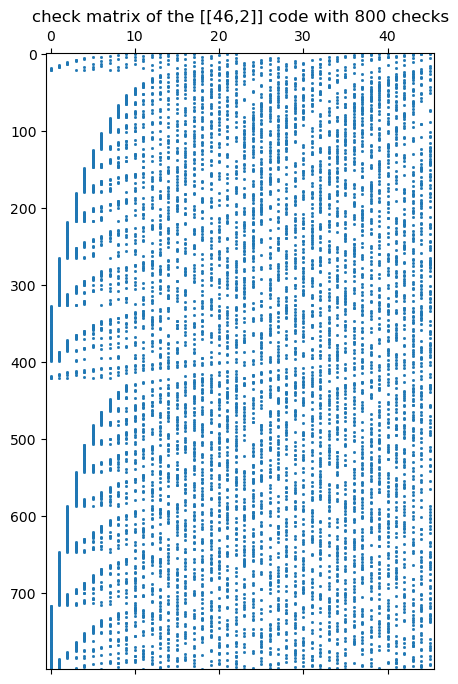

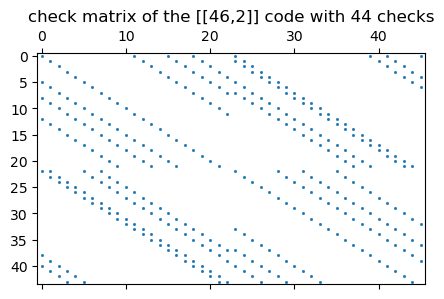

In [6]:
# give parameters for the code and decoder
n = 46
k = 2
m = 800 #number of checks, can also use 46 or 44
m1 = m // 2
m2 = m // 2
n_iterations = 6
codeType = 'GB'

# give parameters for training
#learning rate
lr = 0.001
#training for fixed epsilon_0
ep0 = 0.1
#train on errors of weight ranging from r1 to r2
r1_earlier = 2
r2_earlier = 3
# number of updates
n_batches_earlier = 1500
#number of error patterns in each mini batch
batch_size = 100

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/"
#initialize the decoder, all weights are set to 1
decoder = NBP_oc(n, k, m, m1,m2, codeType, n_iterations, batch_size=batch_size, folder_weights=None)
f = plt.figure(figsize=(5, 8))
plt.spy(decoder.H[0].detach().cpu().numpy(), markersize=1, aspect='auto')
plt.title("check matrix of the [["+str(n)+","+str(k)+"]] code with "+str(m)+" checks")
plt.show()

#for comparision, also plot the original check matrix
decoder_2 = NBP_oc(n, k, n-k, m1,m2, codeType, n_iterations, batch_size=batch_size, folder_weights=None)
f = plt.figure(figsize=(5, 3))
plt.spy(decoder_2.H[0].detach().cpu().numpy(), markersize=1, aspect='auto')
plt.title("check matrix of the [["+str(n)+","+str(k)+"]] code with "+str(n-k)+" checks")
plt.show()

In [8]:
#trainable parameters
parameters = decoder.weights_llr + decoder.weights_cn
#use Adam
optimizer = torch.optim.Adam(parameters, lr=lr)

print('--- Training Metadata ---')
print(f'Code: n={decoder.n}, k={decoder.k}, PCM rows={decoder.m1},{decoder.m2}')
print(f'device: {decoder.device}')
print(f'training ep0 = {ep0}')
print(f'Decoder: {decoder.name}')
print(f'decoding iterations = {decoder.n_iterations}')
print(f'number of batches = {n_batches_earlier}')
print(f'error patterns per batch = {batch_size}')
print(f'learning rate = {lr}\n')

#pre-training stage, basically only the parameters for the first iteration is trained
# 2 箇所 or 3 箇所のエラーでサイズ 100 のミニバッチ * 1500 で学習
loss_pre_train = training_loop(decoder, optimizer, r1_earlier, r2_earlier, ep0, n_batches_earlier, path)
plot_loss(loss_pre_train, path)


#continue to train with higher weight errors, mostly for the later iterations
r1_later = 3
r2_later = 9

n_batches_later = 600
loss = training_loop(decoder, optimizer, r1_later, r2_later, ep0, n_batches_later, path)

plot_loss(torch.cat((loss_pre_train, loss) , dim=0), path)

# loss を pt ファイルで保存
file_loss = "loss.pt"
torch.save(torch.cat((loss_pre_train, loss) , dim=0), os.path.join(path, file_loss))

# params を pt ファイルで保存
params = {
    'n': n,
    'k': k,
    'm': m,
    'm1': m1,
    'm2': m2,
    'n_iterations': n_iterations,
    'codeType': codeType,
    'lr': lr,
    'ep0': ep0,
    'r1_earlier': r1_earlier,
    'r2_earlier': r2_earlier,
    'n_batches_earlier': n_batches_earlier,
    'r1_later': r1_later,
    'r2_later': r2_later,
    'n_batches_later': n_batches_later,
    'batch_size': batch_size
}

file_params = "params.pt"
torch.save(params, os.path.join(path, file_params))

# decoder を pt ファイルで保存
file_decoder = "decoder.pt"
torch.save(decoder, os.path.join(path, file_decoder))

--- Training Metadata ---
Code: n=46, k=2, PCM rows=400,400
device: cuda
training ep0 = 0.1
Decoder: Neural_BP_Decoder
decoding iterations = 6
number of batches = 1500
error patterns per batch = 100
learning rate = 0.001

training on random errors, weight from 2 to 3 


loss 0.19561181962490082:   1%|▏         | 22/1500 [00:06<06:48,  3.62it/s]


KeyboardInterrupt: 

In [ ]:
#call the executable build from the C++ script 'simulateFER.cpp' for evulation
#in case of compatibility issue or wanting to try other codes, re-complie 'simulateFER.cpp' on local machine
import subprocess
subprocess.call(["./NBP_jupyter"])

./NBP_jupyter: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by ./NBP_jupyter)


1

In [ ]:
def check_syndrome(self, Tau):
    """performs hard decision to give the estimated error and check for decoding success.
    However, not used in the current script, as we are only performing trainig"""
    """推定誤差を与えるハード判定を行い、デコードの成功をチェックする。
    しかし、今回のスクリプトでは学習のみを行うため、使用しない。"""
    tmp = torch.zeros(self.batch_size, 1, self.n).to(self.device)
    Tau = torch.cat((tmp, Tau), dim=1)

    minVal, minIdx = torch.min(Tau, dim=1, keepdim=False)

    self.xhat = torch.zeros((self.batch_size, self.n)).to(self.device)
    self.zhat = torch.zeros((self.batch_size, self.n)).to(self.device)

    self.xhat[minIdx == 1] = 1
    self.xhat[minIdx == 2] = 1

    self.zhat[minIdx == 1] = 1
    self.zhat[minIdx == 3] = 1
    m = torch.nn.ReLU()

    synx = torch.matmul(self.Hz, torch.transpose(self.xhat, 0, 1))
    synz = torch.matmul(self.Hx, torch.transpose(self.zhat, 0, 1))
    synx = torch.transpose(synx, 2, 0)
    synz = torch.transpose(synz, 2, 0)
    synhat = torch.remainder(torch.cat((synz, synx), dim=1), 2)

    syn_match = torch.all(torch.all(torch.eq(self.syn, synhat), dim=1), dim=1)

    correctionx = torch.remainder(self.xhat + self.errorx, 2)
    correctionz = torch.remainder(self.zhat + self.errorz, 2)
    synx = torch.matmul(self.Gz, torch.transpose(correctionx, 0, 1))
    synz = torch.matmul(self.Gx, torch.transpose(correctionz, 0, 1))
    synx = torch.transpose(synx, 2, 0)
    synz = torch.transpose(synz, 2, 0)
    self.syn_real = torch.cat((synz, synx), dim=1)

    syn_real = torch.remainder(self.syn_real, 2)
    tmmp = torch.sum(syn_real, dim=1, keepdim=False)
    success = torch.all(torch.eq(torch.sum(syn_real, dim=1, keepdim=False), 0), dim=1)
    return syn_match, success


def decode(decoder, errorx: torch.Tensor, errorz: torch.Tensor, ep: float, batch_size=1):
    """main decoding procedure"""
    loss_array = torch.zeros(decoder.batch_size, decoder.n_iterations).float().to(decoder.device)
    
    # batch_size != self.batch_size のときに例外を投げる
    assert batch_size == decoder.batch_size

    decoder.errorx = errorx.to(decoder.device)
    decoder.errorz = errorz.to(decoder.device)

    # 4 次信念伝播なので 4 変数
    decoder.qx = torch.zeros_like(decoder.errorx)
    decoder.qz = torch.zeros_like(decoder.errorx)
    decoder.qy = torch.zeros_like(decoder.errorx)
    decoder.qi = torch.ones_like(decoder.errorx)

    # x エラーの箇所を 1 にしてから, z エラーがある箇所 (y エラー) を除く
    decoder.qx[decoder.errorx == 1] = 1
    decoder.qx[decoder.errorz == 1] = 0

    # z エラーの箇所を 1 にしてから, x エラーがある箇所 (y エラー) を除く
    decoder.qz[decoder.errorz == 1] = 1
    decoder.qz[decoder.errorx == 1] = 0

    # 一旦 z エラーの箇所を y エラーとしてから, x エラーが無い箇所を除く
    decoder.qy[decoder.errorz == 1] = 1
    decoder.qy[decoder.errorx != decoder.errorz] = 0

    # qi は初め 1 で初期化していることに注意
    # エラーのある箇所を除く
    decoder.qi[decoder.errorx == 1] = 0
    decoder.qi[decoder.errorz == 1] = 0

    decoder.syn = decoder.calculate_self_syn()

    #initial LLR to, first equation in [1,Sec.II-C]
    llr = np.log(3 * (1 - ep) / ep)

    messages_cn_to_vn = torch.zeros((batch_size, decoder.m_oc, decoder.n)).to(decoder.device)
    decoder.batch_size = batch_size

    # initlize VN message
    messages_vn_to_cn, _, _ = decoder.variable_node_update(messages_cn_to_vn, llr, decoder.weights_vn[0],
                                                        decoder.weights_llr[0])

    # iteratively decode, decode will continue till the max. iteration, even if the syndrome already matched
    # 反復デコードでは、シンドロームがすでにマッチしていても、デコードは最大反復まで続けられる。
    for i in range(decoder.n_iterations):

        assert not torch.isnan(decoder.weights_llr[i]).any()
        assert not torch.isnan(decoder.weights_cn[i]).any()
        assert not torch.isnan(messages_cn_to_vn).any()

        # check node update:
        messages_cn_to_vn = decoder.check_node_update(messages_vn_to_cn, decoder.weights_cn[i])

        assert not torch.isnan(messages_cn_to_vn).any()
        assert not torch.isinf(messages_cn_to_vn).any()

        # variable node update:
        messages_vn_to_cn, Tau, Tau_all = decoder.variable_node_update(messages_cn_to_vn, llr, decoder.weights_vn[i + 1],
                                                                    decoder.weights_llr[i + 1])

        assert not torch.isnan(messages_vn_to_cn).any()
        assert not torch.isinf(messages_vn_to_cn).any()
        assert not torch.isnan(Tau).any()
        assert not torch.isinf(Tau).any()

        loss_array[:, i] = decoder.loss(Tau_all)


    _, minIdx = torch.min(loss_array, dim=1, keepdim=False)


    loss = torch.zeros(decoder.batch_size, ).float().to(decoder.device)
    #take average of the loss for the first iterations till the loss is minimized
    #損失が最小になるまでの、最初の反復の損失の平均をとる。
    for b in range(batch_size):
        for idx in range(minIdx[b] + 1):
            loss[b] += loss_array[b, idx]
        loss[b] /= (minIdx[b] + 1)

    loss = torch.sum(loss, dim=0) / decoder.batch_size

    assert not torch.isnan(loss)
    assert not torch.isinf(loss)
    return loss, Tau, Tau_all


In [ ]:
# give parameters for the code and decoder
n = 46
k = 2
m = 800 #number of checks, can also use 46 or 44
m1 = m // 2
m2 = m // 2
n_iterations = 6
codeType = 'GB'

# give parameters for training
#learning rate
lr = 0.001
#training for fixed epsilon_0
ep0 = 0.1
#train on errors of weight ranging from r1 to r2
r1_earlier = 2
r2_earlier = 3
# number of updates
n_batches_earlier = 1500
#number of error patterns in each mini batch
batch_size = 100

# decoder = torch.load(os.path.join(path, file_decoder))
decoder = BP_oc(n, k, m, m1, m2, codeType, n_iterations, batch_size=batch_size)

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "_" + decoder.name + "/"

In [ ]:
print(decoder.name)
print(decoder.codeType)

BP_Decoder
GB


In [ ]:
fers = torch.zeros(n)
n_batches = 200

for w in tqdm(range(1, n + 1)):
    n_fail = 0

    for j in range(n_batches):
        errorx = torch.tensor([])
        errorz = torch.tensor([])
        ex, ez = addErrorGivenWeight(decoder.n, w, batch_size=batch_size)
        errorx = torch.cat((errorx, ex), dim=0)
        errorz = torch.cat((errorz, ez), dim=0)


        decoder.eval()

        with torch.no_grad():
            loss, Tau, Tau_all = decode(decoder, errorx, errorz, ep0, batch_size)

        syn_match, success = decoder.check_syndrome(Tau)

        n_fail += batch_size - torch.sum(success)
    
    fer = n_fail / (n_batches * batch_size)
    fers[w - 1] = fer

# ディレクトリが存在しない場合、作成する
if not os.path.exists(path):
    os.makedirs(path)

# fers を pt ファイルで保存
file_fers = "fers.pt"
torch.save(fers, os.path.join(path, file_fers))


100%|██████████| 46/46 [20:05<00:00, 26.20s/it]


In [ ]:
# ディレクトリが存在しない場合、作成する
if not os.path.exists(path):
    os.makedirs(path)

# fers を pt ファイルで保存
file_fers = "fers.pt"
torch.save(fers, os.path.join(path, file_fers))


In [ ]:
fers

tensor([0.0000, 0.0000, 0.0000, 0.0173, 0.1743, 0.4823, 0.7713, 0.9300, 0.9785,
        0.9889, 0.9917, 0.9955, 0.9952, 0.9973, 0.9975, 0.9979, 0.9981, 0.9975,
        0.9977, 0.9970, 0.9979, 0.9979, 0.9973, 0.9981, 0.9976, 0.9983, 0.9980,
        0.9973, 0.9976, 0.9975, 0.9977, 0.9982, 0.9983, 0.9980, 0.9985, 0.9984,
        0.9976, 0.9977, 0.9977, 0.9974, 0.9977, 0.9981, 0.9980, 0.9975, 0.9982,
        0.9978])

In [ ]:
fers

tensor([0.0000, 0.0137, 0.0709, 0.2201, 0.4689, 0.7031, 0.8453, 0.9084, 0.9443,
        0.9604, 0.9658, 0.9735, 0.9754, 0.9795, 0.9815, 0.9800, 0.9811, 0.9809,
        0.9794, 0.9793, 0.9812, 0.9813, 0.9789, 0.9806, 0.9814, 0.9790, 0.9807,
        0.9795, 0.9803, 0.9811, 0.9781, 0.9779])

In [ ]:
decoder.eval()

with torch.no_grad():
    loss, Tau, Tau_all = decode(decoder, errorx, errorz, ep0, batch_size=100)


In [ ]:
Tau.size()

torch.Size([100, 3, 46])

In [ ]:
Tau_all.size()

torch.Size([100, 2, 46])

In [ ]:
syn_match, success = decoder.check_syndrome(Tau)

In [ ]:
syn_match

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')

In [ ]:
success

tensor([False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
         True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [ ]:
n = 46
k = 2
m = 800

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/" + "fers.pt"

fers_nbp_gb = torch.load(path)
fers_nbp_gb.size()

torch.Size([46])

In [ ]:
n = 46
k = 2
m = 800

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "_BP_Decoder" + "/" + "fers.pt"

fers_bp_gb = torch.load(path)
fers_bp_gb.size()

torch.Size([46])

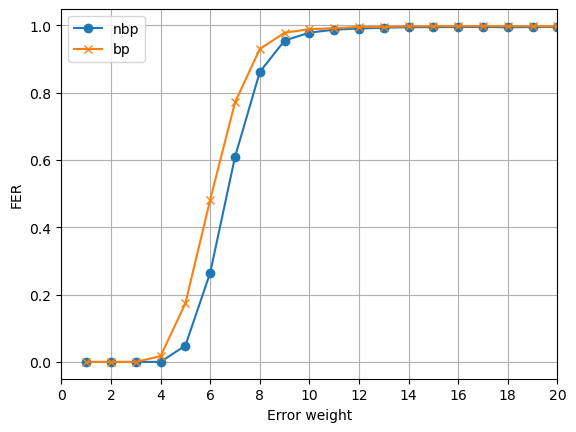

In [ ]:
import matplotlib.ticker as ticker


x = np.array(range(1, 47))
plt.plot(x, fers_nbp_gb, label='nbp', marker='o')
plt.plot(x, fers_bp_gb, label='bp', marker='x')
plt.xlabel('Error weight')
plt.ylabel('FER')
plt.xlim(0, 20)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid()
plt.legend()
plt.show()

In [ ]:
n = 32
k = 2
m = 96
codeType = 'toric'

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/" + "fers.pt"

fers_nbp_toric = torch.load(path)
fers_nbp_toric.size()

torch.Size([32])

In [ ]:
n = 32
k = 2
m = 96
codeType = 'toric'

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "_BP_Decoder" + "/" + "fers.pt"

fers_bp_toric = torch.load(path)
fers_bp_toric.size()

torch.Size([32])

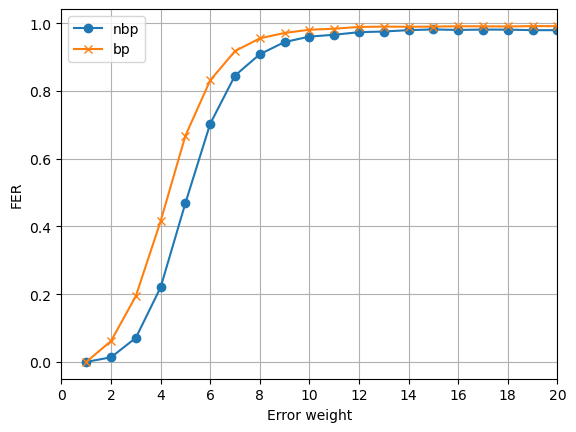

In [ ]:
x = np.array(range(1, 33))
plt.plot(x, fers_nbp_toric, label='nbp', marker='o')
plt.plot(x, fers_bp_toric, label='bp', marker='x')
plt.xlabel('Error weight')
plt.ylabel('FER')
plt.xlim(0, 20)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid()
plt.legend()
plt.show()